In [1]:
'''
Here we will learn about logistic regression using tf estimator.
We will learn DNN classifier and linear classifier.

'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import pandas as pd
import tensorflow as tf

### Here let us pull some real data

In [2]:
# We will take the diabetes csv as our data.
diabetes=pd.read_csv("pima-indians-diabetes.csv")

In [10]:
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [4]:
diabetes.describe()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,0.607510,0.566438,0.207439,0.094326,0.476790,0.168179,33.240885,0.348958
std,3.369578,0.160666,0.158654,0.161134,0.136222,0.117499,0.141473,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000
25%,1.000000,0.497487,0.508197,0.000000,0.000000,0.406855,0.070773,24.000000,0.000000
50%,3.000000,0.587940,0.590164,0.232323,0.036052,0.476900,0.125747,29.000000,0.000000
75%,6.000000,0.704774,0.655738,0.323232,0.150414,0.545455,0.234095,41.000000,1.000000
max,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81.000000,1.000000


In [5]:
diabetes.columns

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')

## Here we all have numerical values where in the feture coulumns we can mention it, except the last column which is group. The column is intentionally added to make work on text data as well.

#### Now we will normalise the columns
#### We chose Scaling to a range normalization type.
##### Group is character we cannot, Class is output, Age we are going to use it as categorical column. So we remove these 3 columns.

In [6]:
cols_to_norm=['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree']

In [31]:
## Lets normalise with pandas.
diabetes[cols_to_norm]=diabetes[cols_to_norm].apply(lambda x:
                                                    (
                                                        (x-x.min())/
                                                     (x.max()-x.min())
                                                    )
                                                   )

In [32]:
#Now lets see the value
diabetes.tail()
#Every thing is scaled to a range

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,63,0,B
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,27,0,A
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,30,0,C
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,47,1,C
767,0.058824,0.467337,0.573770,0.313131,0.000000,0.453055,0.101196,23,0,A


In [33]:
diabetes.columns

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')

### lets create our feature columns
#### As we have more columns to consider we will create each manually.

In [34]:
num_preg=tf.feature_column.numeric_column('Number_pregnant')
plasma_gloc=tf.feature_column.numeric_column('Glucose_concentration')
bp=tf.feature_column.numeric_column('Blood_pressure')
triceps=tf.feature_column.numeric_column('Triceps')
insulin=tf.feature_column.numeric_column('Insulin')
bmi=tf.feature_column.numeric_column('BMI')
pedigree=tf.feature_column.numeric_column('Pedigree')
age=tf.feature_column.numeric_column('Age')


#### the above are numerical values. But there are categorical values also.
#### There are two ways to make it
#### One with Vocabulary list and one with hash bucket
#### Vocabulary list:
##### Here we know how many categories would present, so we wil place them in the list and pass it to vocabulary list.

In [36]:
voca_group=tf.feature_column.categorical_column_with_vocabulary_list('Group',['A','B','C','D'])

#### the second is hash bucket
##### When you dn't know how many values are present in the column or too many values(Eg: All the  countries in the world), then we use hash bucket.
##### Here instead of values like vocabulary we will give the max. number of values in the column.

In [38]:
hash_group=tf.feature_column.categorical_column_with_hash_bucket('Group',hash_bucket_size=4)

##### As of now we will use the vocabulary list

#### We have the age column to take care of.
##### Lets visualize it.

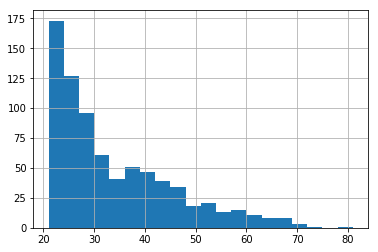

In [40]:
diabetes['Age'].hist(bins=20)

#### Here the plot is un-equally distributed. WE will normalize it using bucketing concept. Which i wrote in the tensorflow Book_1

In [42]:
## here we will pass the column name and list of the boundaries we need it.
age_bucket=tf.feature_column.bucketized_column(age,boundaries=[20,30,40,50,60,70,80])

#### Lets make list of all feature columns

In [43]:
feat_cols=[num_preg,plasma_gloc,bp,triceps,insulin,bmi,pedigree,voca_group,age_bucket]

In [45]:
#### Lets split train test data.
y_data=diabetes['Class']
x_data=diabetes.drop('Class',axis=1)

In [46]:
x_data.tail()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,63,B
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,27,A
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,30,C
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,47,C
767,0.058824,0.467337,0.573770,0.313131,0.000000,0.453055,0.101196,23,A


In [47]:
y_data.tail()

763    0
764    0
765    0
766    1
767    0
Name: Class, dtype: int64

In [48]:
x_train,x_eval,y_train,y_eval=train_test_split(x_data,
                                               y_data,
                                               test_size=0.3,
                                               random_state=101
                                          )

In [49]:
x_train.shape

(537, 9)

In [50]:
x_eval.shape

(231, 9)

#### Now we have split the data. Now lets train the model

In [51]:
input_func=tf.estimator.inputs.pandas_input_fn(x=x_train,
                                               y=y_train,
                                              batch_size=10,
                                              num_epochs=1000,
                                               shuffle=True)

#### Lets create a model 
##### Here we give the n_classes (by default is 2) to tell the model how many output classes are present.

In [53]:
# Lets crete model
estimator=tf.estimator.LinearClassifier(feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffa9f0cb908>, '_protocol': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_task_type': 'worker', '_train_distribute': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_eval_distribute': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_experimental_max_worker_delay_secs': None, '_global_id_in_cluster': 0, '_device_fn': None, '_model_dir': '/tmp/tmp56wrosxf', '_save_checkpoints_steps': None, '_session_creation_timeout_secs': 7200, '_is_chief': True, '_log_step_count_steps': 100, '_evaluation_master': '', '_task_id': 0}


### Lets train the model

In [54]:
estimator.train(input_fn=input_func,steps=1000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp56wrosxf/mo

#### Lets evaluate model

In [56]:
eval_input_func=tf.estimator.inputs.pandas_input_fn(x=x_eval,y=y_eval,batch_size=10,num_epochs=1,shuffle=False)

In [58]:
results=estimator.evaluate(input_fn=eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-15T18:41:20Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp56wrosxf/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-03-15-18:41:21
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7186147, accuracy_baseline = 0.64935064, auc = 0.77893007, auc_precision_recall = 0.6304506, average_loss = 0.573841, global_step = 1000, label/mean = 0.35064936, loss = 5.5232196, precision = 0.7105263, prediction/mean = 0.37370837, recall = 0.33333334
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp56wrosxf/model.ckpt-1000


In [59]:
results

{'accuracy': 0.7186147,
 'accuracy_baseline': 0.64935064,
 'auc': 0.77893007,
 'auc_precision_recall': 0.6304506,
 'average_loss': 0.573841,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 5.5232196,
 'precision': 0.7105263,
 'prediction/mean': 0.37370837,
 'recall': 0.33333334}

##### the accuracy is 64% which is not bad. But the precision and recall is bit low where we have to bother about. Lets predict some values.

In [61]:
pred_input_func=tf.estimator.inputs.pandas_input_fn(x=x_eval,batch_size=10,num_epochs=1,shuffle=False)

In [62]:
pred_input_func

<function tensorflow_estimator.python.estimator.inputs.pandas_io.pandas_input_fn.<locals>.input_fn()>

In [67]:
#### Now lets predict the model.
predictions=list(estimator.predict(input_fn=pred_input_func))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp56wrosxf/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [69]:
# We wont print because it is very loarge list of all the predictions.
#predictions

# Till now we did with Linear classifier
*** Now we will do with DNN classifier ***
##### Hidden_layers= how many neurons and how many layers we need for that classifier.(we can provide in a list eg: [10,2,10], which means 10 neurons for 1st layer 2 for 2nd and 10 for third respectively.)
##### 

In [78]:
dnn_model=tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffa94214ef0>, '_protocol': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_task_type': 'worker', '_train_distribute': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_eval_distribute': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_experimental_max_worker_delay_secs': None, '_global_id_in_cluster': 0, '_device_fn': None, '_model_dir': '/tmp/tmpgpt_hmlf', '_save_checkpoints_steps': None, '_session_creation_timeout_secs': 7200, '_is_chief': True, '_log_step_count_steps': 100, '_evaluation_master': '', '_task_id': 0}


# NOw lets train the model.

In [79]:
dnn_model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgpt_hmlf/model.ckpt.
INFO:tensorflow:loss = 6.9962645, step = 1
INFO:tensorflow:global_step/sec: 289.817
INFO:tensorflow:loss = 4.8218718, step = 101 (0.346 sec)
INFO:tensorflow:global_step/sec: 380.362
INFO:tensorflow:loss = 6.206402, step = 201 (0.261 sec)
INFO:tensorflow:global_step/sec: 366.555
INFO:tensorflow:loss = 6.1658406, step = 301 (0.275 sec)
INFO:tensorflow:global_step/sec: 382.394
INFO:tensorflow:loss = 5.713536, step = 401 (0.262 sec)
INFO:tensorflow:global_step/sec: 362.428
INFO:tensorflow:loss = 7.0578055, step = 501 (0.274 sec)
INFO:tensorflow:global_step/sec: 372.848
INFO:tensorflow:loss = 6.720974, step = 601 (0.272 sec)
INFO:tensorflow:global_step/sec: 376.412
INFO:tensorflow:los

## Now lets evaluate the model

In [80]:
dnn_eval=dnn_model.evaluate(input_fn=eval_input_func,steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-15T18:57:26Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgpt_hmlf/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2020-03-15-18:57:26
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.5, accuracy_baseline = 0.5, auc = 0.38000005, auc_precision_recall = 0.3904763, average_loss = 0.77106035, global_step = 1000, label/mean = 0.5, loss = 7.710603, precision = 0.0, prediction/mean = 0.33211166, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpgpt_hmlf/model.ckpt-1000


In [81]:
dnn_eval

{'accuracy': 0.5,
 'accuracy_baseline': 0.5,
 'auc': 0.38000005,
 'auc_precision_recall': 0.3904763,
 'average_loss': 0.77106035,
 'global_step': 1000,
 'label/mean': 0.5,
 'loss': 7.710603,
 'precision': 0.0,
 'prediction/mean': 0.33211166,
 'recall': 0.0}

In [85]:
embedded_group_col=tf.feature_column.embedding_column(voca_group,dimension=4)

In [86]:
feat_cols=[num_preg,plasma_gloc,bp,triceps,insulin,bmi,pedigree,embedded_group_col,age_bucket]

In [87]:
input_func=tf.estimator.inputs.pandas_input_fn(x=x_train,y=y_train,
                                          batch_size=10,
                                              num_epochs=1000,shuffle=False)

In [88]:
dnn_model=tf.estimator.DNNClassifier([10,10,10],feature_columns=feat_cols,n_classes=2,)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffa9de2bb70>, '_protocol': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_task_type': 'worker', '_train_distribute': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_eval_distribute': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_experimental_max_worker_delay_secs': None, '_global_id_in_cluster': 0, '_device_fn': None, '_model_dir': '/tmp/tmppscoagpg', '_save_checkpoints_steps': None, '_session_creation_timeout_secs': 7200, '_is_chief': True, '_log_step_count_steps': 100, '_evaluation_master': '', '_task_id': 0}


In [89]:
# Lets train
dnn_model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppscoagpg/model.ckpt.
INFO:tensorflow:loss = 6.629996, step = 1
INFO:tensorflow:global_step/sec: 242.168
INFO:tensorflow:loss = 7.2511024, step = 101 (0.414 sec)
INFO:tensorflow:global_step/sec: 375.252
INFO:tensorflow:loss = 6.7987275, step = 201 (0.272 sec)
INFO:tensorflow:global_step/sec: 341.372
INFO:tensorflow:loss = 10.385097, step = 301 (0.287 sec)
INFO:tensorflow:global_step/sec: 349.061
INFO:tensorflow:loss = 4.883558, step = 401 (0.287 sec)
INFO:tensorflow:global_step/sec: 328.527
INFO:tensorflow:loss = 3.1814513, step = 501 (0.304 sec)
INFO:tensorflow:global_step/sec: 

In [92]:
eval_input_func=tf.estimator.inputs.pandas_input_fn(x=x_eval,y=y_eval,batch_size=10,num_epochs=1,shuffle=False)

In [93]:
evaluate=dnn_model.evaluate(input_fn=eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-15T19:09:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppscoagpg/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-03-15-19:09:01
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.76623374, accuracy_baseline = 0.64935064, auc = 0.8293004, auc_precision_recall = 0.6928384, average_loss = 0.48119882, global_step = 1000, label/mean = 0.35064936, loss = 4.631539, precision = 0.65882355, prediction/mean = 0.37801057, recall = 0.69135803
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmppscoagpg/model.ckpt-1000


In [94]:
evaluate

{'accuracy': 0.76623374,
 'accuracy_baseline': 0.64935064,
 'auc': 0.8293004,
 'auc_precision_recall': 0.6928384,
 'average_loss': 0.48119882,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 4.631539,
 'precision': 0.65882355,
 'prediction/mean': 0.37801057,
 'recall': 0.69135803}

In [97]:
#lets predict the model with test data itself.
predict_input_func=tf.estimator.inputs.pandas_input_fn(x=x_eval,batch_size=10,num_epochs=1,shuffle=False)
preditcions=list(dnn_model.predict(input_fn=predict_input_func))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppscoagpg/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [98]:
preditcions

[{'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([0.5794473], dtype=float32),
  'logits': array([0.32050514], dtype=float32),
  'probabilities': array([0.42055264, 0.5794473 ], dtype=float32)},
 {'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([0.7391421], dtype=float32),
  'logits': array([1.0415145], dtype=float32),
  'probabilities': array([0.26085785, 0.7391421 ], dtype=float32)},
 {'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.21928966], dtype=float32),
  'logits': array([-1.2698107], dtype=float32),
  'probabilities': array([0.78071034, 0.21928968], dtype=float32)},
 